In [51]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers, _butter_lowpass, _align_trajectories_with_walking_direction, _get_start_end_index, _get_data_from_marker
from lib.analysis import _get_gait_events_from_OMC, _get_gait_events_from_IMU, _extract_temporal_gait_params
import os
from scipy.signal import find_peaks
from lib.postprocessing import _compare_events

In [52]:
pid = "pp125"

In [53]:
PARENT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"  # on Linux
OUTPUT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Output/lab dataset"  # on Linux
participant_ids = [folder_name for folder_name in os.listdir(PARENT_FOLDER) if folder_name.startswith("pp")]
trial_name = "walk_preferred"
ix_participant = participant_ids.index(pid)
participant_id = participant_ids[ix_participant]
omc_filenames = [file_name for file_name in os.listdir(os.path.join(PARENT_FOLDER, participant_id, "optical")) if file_name.endswith(".mat")]
ix_omc_filename = [ix for ix in range(len(omc_filenames)) if (trial_name in omc_filenames[ix])]
if len(ix_omc_filename) > 0:
    omc_filename = omc_filenames[ix_omc_filename[0]]
if os.path.isfile(os.path.join(PARENT_FOLDER, participant_id, "imu", omc_filename.replace("omc_", "imu_"))):
    imu_filename = omc_filename.replace("omc_", "imu_")
    
    # Load the optical motion capture data
    omc_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "optical", omc_filename))
    fs_omc = omc_data["fs"]

    # 0. Get sampling frequency, raw marker data, and data dimensions
    n_time_steps, n_dimensions, n_markers = omc_data["pos"][:,:3,:].shape

    # 0. Check if marker data is available for all relevant markers
    l_heel_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='l_heel')
    r_heel_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='r_heel')
    l_toe_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='l_toe')
    r_toe_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='r_toe')
    l_psis_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='l_psis')
    r_psis_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='r_psis')
    l_asis_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='l_asis')
    r_asis_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='r_asis')
    if (l_heel_pos is None) or (l_toe_pos is None) or (l_psis_pos is None) or (l_asis_pos is None) or (r_heel_pos is None) or (r_toe_pos is None) or (r_psis_pos is None) or (r_asis_pos is None):
        print("Missing some marker data!")

raw_data = np.reshape(omc_data["pos"][:,:3,:], (n_time_steps, n_dimensions * n_markers), order="F")
filled_data = _predict_missing_markers(raw_data)
filtered_data = _butter_lowpass(filled_data, fs_omc)
filtered_data = np.reshape(filtered_data, (n_time_steps, n_dimensions, n_markers), order="F")
ix_start, ix_end = _get_start_end_index(filtered_data, omc_data["marker_location"])
aligned_data = _align_trajectories_with_walking_direction(filtered_data, omc_data["marker_location"])
# 4. Detect gait events
l_ix_IC_OMC_1, l_ix_FC_OMC_1, r_ix_IC_OMC_1, r_ix_FC_OMC_1 = _get_gait_events_from_OMC(aligned_data, fs_omc, omc_data["marker_location"], method="Pijnappels")
l_ix_IC_OMC_2, l_ix_FC_OMC_2, r_ix_IC_OMC_2, r_ix_FC_OMC_2 = _get_gait_events_from_OMC(aligned_data, fs_omc, omc_data["marker_location"], method="OConnor")
l_ix_IC_OMC_3, l_ix_FC_OMC_3, r_ix_IC_OMC_3, r_ix_FC_OMC_3 = _get_gait_events_from_OMC(aligned_data, fs_omc, omc_data["marker_location"], method="ZeniJr")

velocity = np.zeros_like(aligned_data)
velocity[1:,:,:] = ( aligned_data[1:,:,:] - aligned_data[:-1,:,:] ) / (1/fs_omc)
velocity[0,:,:] = velocity[1,:,:]

acceleration = np.zeros_like(velocity)
acceleration[1:,:,:] = ( velocity[1:,:,:] - velocity[:-1,:,:] ) / (1/fs_omc)
acceleration[0,:,:] = acceleration[1,:,:]

# Get relevant markers
l_psis_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="l_psis")[:,0]], axis=-1)
r_psis_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="r_psis")[:,0]], axis=-1)
l_asis_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="l_asis")[:,0]], axis=-1)
r_asis_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="r_asis")[:,0]], axis=-1)
pelvis_pos = ( l_psis_pos + r_psis_pos + l_asis_pos + r_asis_pos ) / 4

l_heel_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], axis=-1)
r_heel_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], axis=-1)
l_toe_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="l_toe")[:,0]], axis=-1)
r_toe_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="r_toe")[:,0]], axis=-1)
l_mid_foot_pos = ( l_heel_pos + l_toe_pos ) / 2
r_mid_foot_pos = ( r_heel_pos + r_toe_pos ) / 2

start_1 = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="start_1")[:,0]], axis=-1)
start_2 = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="start_2")[:,0]], axis=-1)
end_1 = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="end_1")[:,0]], axis=-1)
end_2 = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="end_2")[:,0]], axis=-1)

# Velocity and accelerations
l_heel_vel = np.squeeze(velocity[:,:,np.argwhere(omc_data["marker_location"]=='l_heel')[:,0]], axis=-1)
r_heel_vel = np.squeeze(velocity[:,:,np.argwhere(omc_data["marker_location"]=='r_heel')[:,0]], axis=-1)
l_toe_vel = np.squeeze(velocity[:,:,np.argwhere(omc_data["marker_location"]=='l_toe')[:,0]], axis=-1)
r_toe_vel = np.squeeze(velocity[:,:,np.argwhere(omc_data["marker_location"]=='r_toe')[:,0]], axis=-1)
l_mid_foot_vel = ( l_heel_vel + l_toe_vel ) / 2
r_mid_foot_vel = ( r_heel_vel + r_toe_vel ) / 2



In [54]:
# Detect peaks in forward velocity
l_thr_min_vel_x = 0.1*(np.max(l_mid_foot_vel[:,0]) - np.min(l_mid_foot_vel[:,0]))
l_ix_max_vel_x, _ = find_peaks(l_mid_foot_vel[:,0], height=l_thr_min_vel_x, distance=fs_omc//4)

r_thr_min_vel_x = 0.1*(np.max(r_mid_foot_vel[:,0]) - np.min(r_mid_foot_vel[:,0]))
r_ix_max_vel_x, _ = find_peaks(r_mid_foot_vel[:,0], height=r_thr_min_vel_x, distance=fs_omc//4)

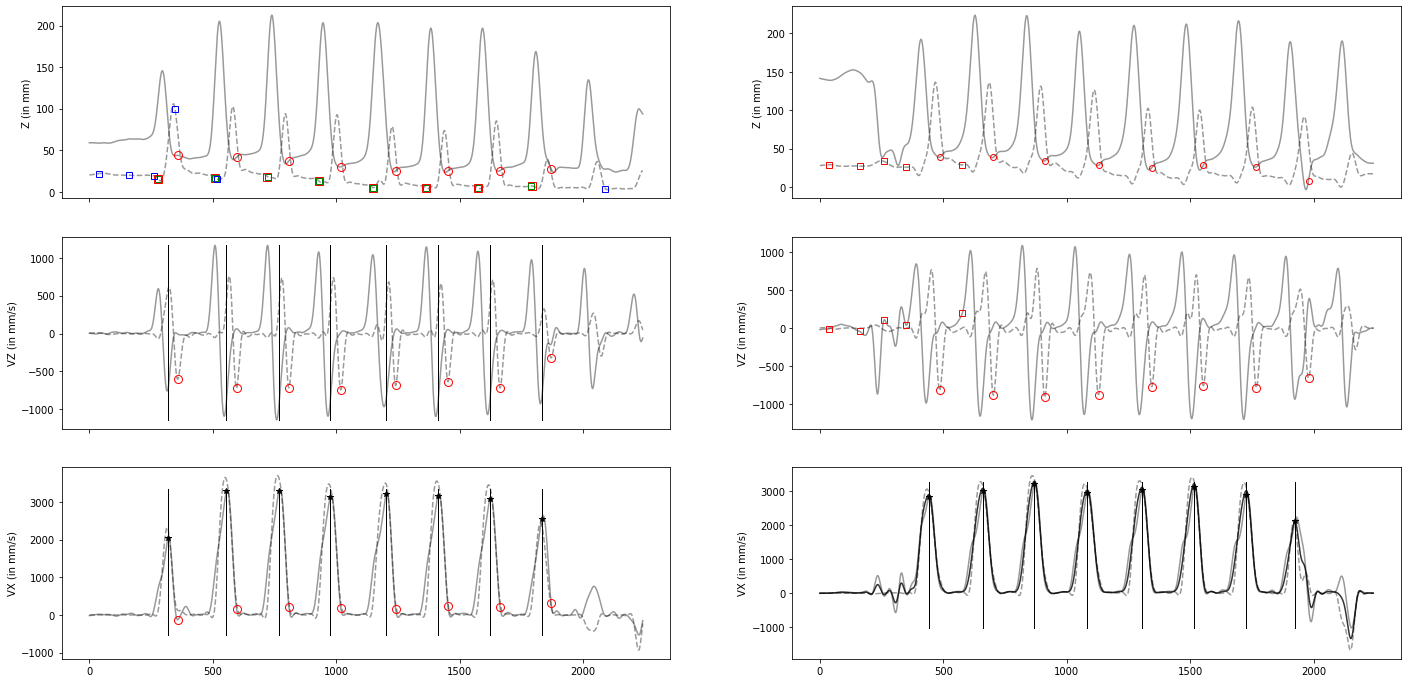

In [57]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(24, 12))

# --- Left ---
axs[0][0].plot(l_heel_pos[:,2], '-', c=(0, 0, 0, 0.4))
axs[0][0].plot(l_toe_pos[:,2], '--', c=(0, 0, 0, 0.4))
axs[0][0].plot(l_ix_IC_OMC_1, l_heel_pos[l_ix_IC_OMC_1,2], 'o', mfc='none', mec='r', ms=8, label='IC (Pijnappels)')
axs[0][0].plot(l_ix_FC_OMC_1, l_toe_pos[l_ix_FC_OMC_1,2], 's', mfc='none', mec='r', ms=8, label='FC (Pijnappels)')
axs[0][0].plot(l_ix_FC_OMC_2, l_toe_pos[l_ix_FC_OMC_2,2], 's', mfc='none', mec='g', ms=6, label='FC (OConnor)')
axs[0][0].plot(l_ix_FC_OMC_3, l_toe_pos[l_ix_FC_OMC_3,2], 's', mfc='none', mec='b', label='FC (Zeni Jr)')
axs[0][0].set_ylabel('Z (in mm)')

axs[1][0].plot(l_heel_vel[:,2], '-', c=(0, 0, 0, 0.4))
axs[1][0].plot(l_toe_vel[:,2], '--', c=(0, 0, 0, 0.4))
for i in range(len(l_ix_max_vel_x)):
    axs[1][0].plot([l_ix_max_vel_x[i], l_ix_max_vel_x[i]], [min(l_heel_vel[:,2]), max(l_heel_vel[:,2])], 'k-', lw=1)
axs[1][0].plot(l_ix_IC_OMC_1, l_toe_vel[l_ix_IC_OMC_1,2], 'o', mfc='none', mec='r', ms=8, label='IC (Pijnappels)')
# axs[1][0].plot(l_pks_toe_vel_z, l_toe_vel[l_pks_toe_vel_z,2], 'x', mfc='none', mec='r', ms=12, label='IC (Pijnappels)')
axs[1][0].set_ylabel('VZ (in mm/s)')

axs[2][0].plot(l_heel_vel[:,0], '-', c=(0, 0, 0, 0.4))
axs[2][0].plot(l_toe_vel[:,0], '--', c=(0, 0, 0, 0.4))
axs[2][0].plot(l_ix_max_vel_x, l_heel_vel[l_ix_max_vel_x,0], 'k*')
for i in range(len(l_ix_max_vel_x)):
    axs[2][0].plot([l_ix_max_vel_x[i], l_ix_max_vel_x[i]], [min(l_heel_vel[:,0]), max(l_heel_vel[:,0])], 'k-', lw=1)
axs[2][0].plot(l_ix_IC_OMC_1, l_heel_vel[l_ix_IC_OMC_1,0], 'o', mfc='none', mec='r', ms=8)
axs[2][0].set_ylabel('VX (in mm/s)')

# --- Right ---
axs[0][1].plot(r_heel_pos[:,2], '-', c=(0, 0, 0, 0.4))
axs[0][1].plot(r_toe_pos[:,2], '--', c=(0, 0, 0, 0.4))
axs[0][1].plot(r_ix_IC_OMC_1, r_heel_pos[r_ix_IC_OMC_1,2], 'o', mfc='none', mec='r')
axs[0][1].plot(r_ix_FC_OMC_3, r_toe_pos[r_ix_FC_OMC_3,2], 's', mfc='none', mec='r')
axs[0][1].set_ylabel('Z (in mm)')

axs[1][1].plot(r_heel_vel[:,2], '-', c=(0, 0, 0, 0.4))
axs[1][1].plot(r_toe_vel[:,2], '--', c=(0, 0, 0, 0.4))
axs[1][1].plot(r_ix_IC_OMC_1, r_toe_vel[r_ix_IC_OMC_1,2], 'o', mfc='none', mec='r', ms=8, label='IC (Pijnappels)')
axs[1][1].plot(r_ix_FC_OMC_3, r_heel_vel[r_ix_FC_OMC_3,2], 's', mfc='none', mec='r', label='FC (Zeni Jr)')
axs[1][1].set_ylabel('VZ (in mm/s)')

axs[2][1].plot(r_heel_vel[:,0], '-', c=(0, 0, 0, 0.4))
axs[2][1].plot(r_toe_vel[:,0], '--', c=(0, 0, 0, 0.4))
axs[2][1].plot(r_mid_foot_vel[:,0], '-', c=(0, 0, 0, 0.8))
axs[2][1].plot(r_ix_max_vel_x, r_heel_vel[r_ix_max_vel_x,0], 'k*')
for i in range(len(r_ix_max_vel_x)):
    axs[2][1].plot([r_ix_max_vel_x[i], r_ix_max_vel_x[i]], [min(r_heel_vel[:,0]), max(r_heel_vel[:,0])], 'k-', lw=1)
axs[2][1].set_ylabel('VX (in mm/s)')
plt.show()

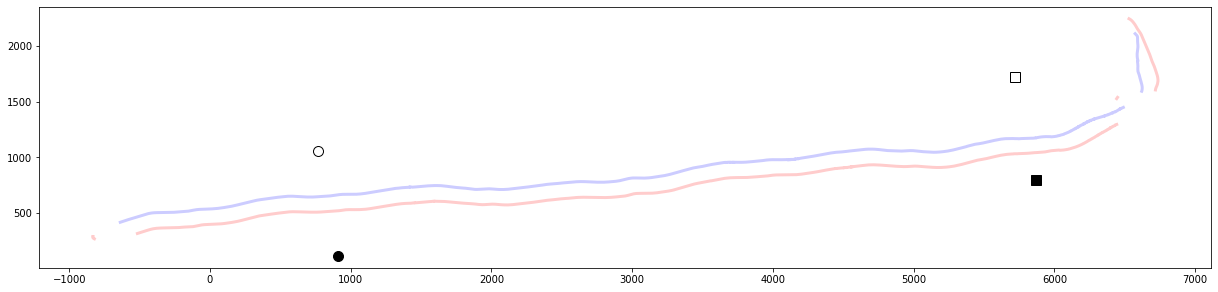

In [65]:
fig, axs = plt.subplots(1, 1, figsize=(21., 4.8))
axs.plot(np.nanmean(omc_data['pos'][:,0,np.argwhere(omc_data['marker_location']=='start_1')[:,0][0]]), np.nanmean(omc_data['pos'][:,1,np.argwhere(omc_data['marker_location']=='start_1')[:,0][0]]), 'o', mfc='none', mec='k', ms=10)
axs.plot(np.nanmean(omc_data['pos'][:,0,np.argwhere(omc_data['marker_location']=='start_2')[:,0][0]]), np.nanmean(omc_data['pos'][:,1,np.argwhere(omc_data['marker_location']=='start_2')[:,0][0]]), 'o', mfc='k', mec='k', ms=10)
axs.plot(np.nanmean(omc_data['pos'][:,0,np.argwhere(omc_data['marker_location']=='end_1')[:,0][0]]), np.nanmean(omc_data['pos'][:,1,np.argwhere(omc_data['marker_location']=='end_1')[:,0][0]]), 's', mfc='none', mec='k', ms=10)
axs.plot(np.nanmean(omc_data['pos'][:,0,np.argwhere(omc_data['marker_location']=='end_2')[:,0][0]]), np.nanmean(omc_data['pos'][:,1,np.argwhere(omc_data['marker_location']=='end_2')[:,0][0]]), 's', mfc='k', mec='k', ms=10)
axs.plot(omc_data['pos'][:,0,np.argwhere(omc_data['marker_location']=='l_psis')[:,0][0]], omc_data['pos'][:,1,np.argwhere(omc_data['marker_location']=='l_psis')[:,0][0]], ls='-', lw=3, c=(0, 0, 1, 0.2))
axs.plot(omc_data['pos'][:,0,np.argwhere(omc_data['marker_location']=='r_psis')[:,0][0]], omc_data['pos'][:,1,np.argwhere(omc_data['marker_location']=='r_psis')[:,0][0]], ls='-', lw=3, c=(1, 0, 0, 0.2))
plt.show()

Minimum at sample: 703


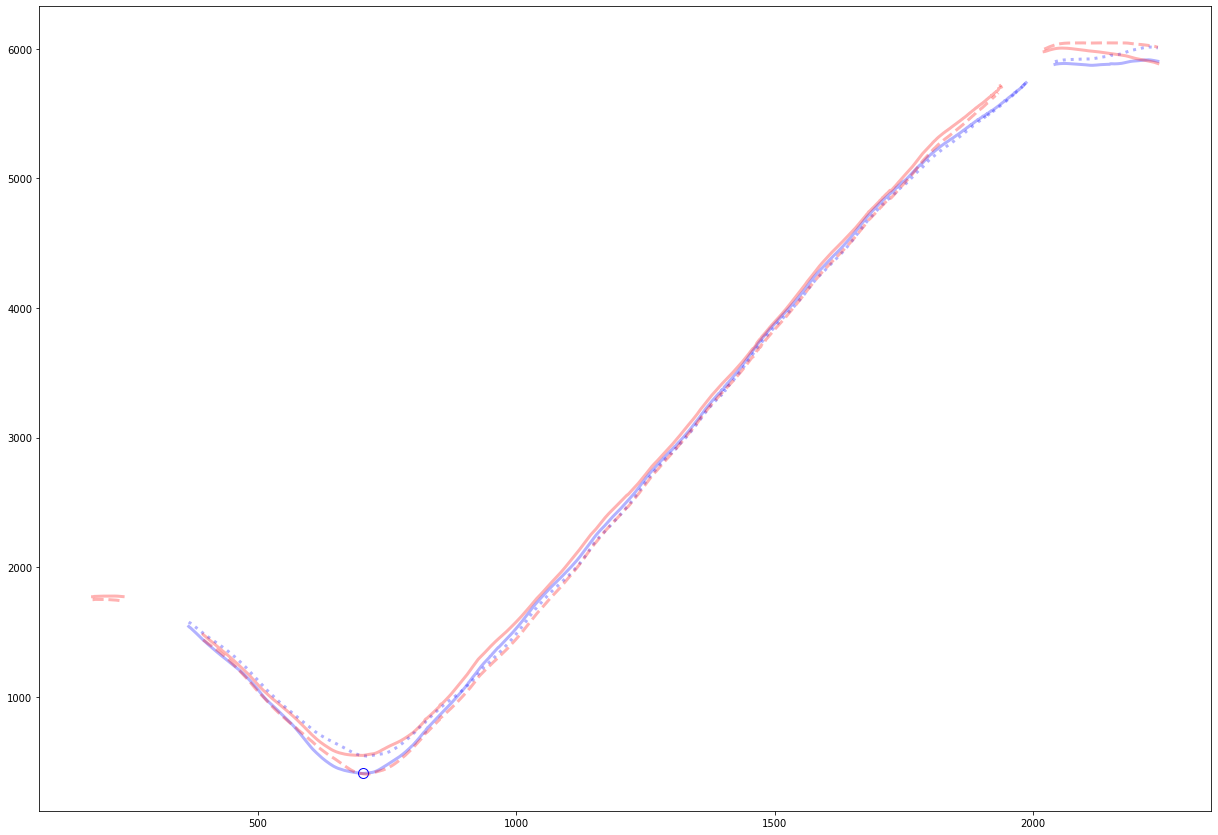

In [71]:
# Distance to start marker(s)
l_distance_1 = np.sqrt(np.sum((omc_data['pos'][:,:2,np.argwhere(omc_data['marker_location']=='l_psis')[:,0][0]] - omc_data['pos'][:,:2,np.argwhere(omc_data['marker_location']=='start_1')[:,0][0]])**2, axis=1))
l_distance_2 = np.sqrt(np.sum((omc_data['pos'][:,:2,np.argwhere(omc_data['marker_location']=='l_psis')[:,0][0]] - omc_data['pos'][:,:2,np.argwhere(omc_data['marker_location']=='start_2')[:,0][0]])**2, axis=1))
r_distance_1 = np.sqrt(np.sum((omc_data['pos'][:,:2,np.argwhere(omc_data['marker_location']=='r_psis')[:,0][0]] - omc_data['pos'][:,:2,np.argwhere(omc_data['marker_location']=='start_1')[:,0][0]])**2, axis=1))
r_distance_2 = np.sqrt(np.sum((omc_data['pos'][:,:2,np.argwhere(omc_data['marker_location']=='r_psis')[:,0][0]] - omc_data['pos'][:,:2,np.argwhere(omc_data['marker_location']=='start_2')[:,0][0]])**2, axis=1))

# Find mininum
ix_min = np.nanargmin(l_distance_1)
print(f"Minimum at sample: {ix_min}")

# Plot
fig, axs = plt.subplots(1, 1, figsize=(21., 14.8))
axs.plot(l_distance_1, ls='-', c=(0, 0, 1, 0.3), lw=3)
axs.plot(ix_min, l_distance_1[ix_min], 'o', mfc='none', mec=(0, 0, 1), ms=10)
axs.plot(l_distance_2, ls=':', c=(0, 0, 1, 0.3), lw=3)
axs.plot(r_distance_1, ls='-', c=(1, 0, 0, 0.3), lw=3)
axs.plot(r_distance_2, ls='--', c=(1, 0, 0, 0.3), lw=3)
axs.plot()
plt.show()

In [42]:
imu_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, 'imu', imu_filename))
print(imu_data.keys())
fs_imu = np.array(imu_data['fs']).astype('float')
print(f"Sampling frequency: {fs_imu} Hz")

dict_keys(['calibration_file', 'acc', 'gyro', 'magn', 'fs', 'imu_location'])
Sampling frequency: 200.0 Hz


In [50]:
print(imu_data['gyro'].shape)

(2021, 3, 5)


In [43]:
l_ank_acc = imu_data['acc'][:,:,np.argwhere(imu_data['imu_location']=='left_ankle')[:,0][0]]
l_ank_gyro = imu_data['gyro'][:,:,np.argwhere(imu_data['imu_location']=='left_ankle')[:,0][0]]
r_ank_acc = imu_data['acc'][:,:,np.argwhere(imu_data['imu_location']=='right_ankle')[:,0][0]]
r_ank_gyro = imu_data['gyro'][:,:,np.argwhere(imu_data['imu_location']=='right_ankle')[:,0][0]]

IndexError: index 13 is out of bounds for axis 2 with size 5

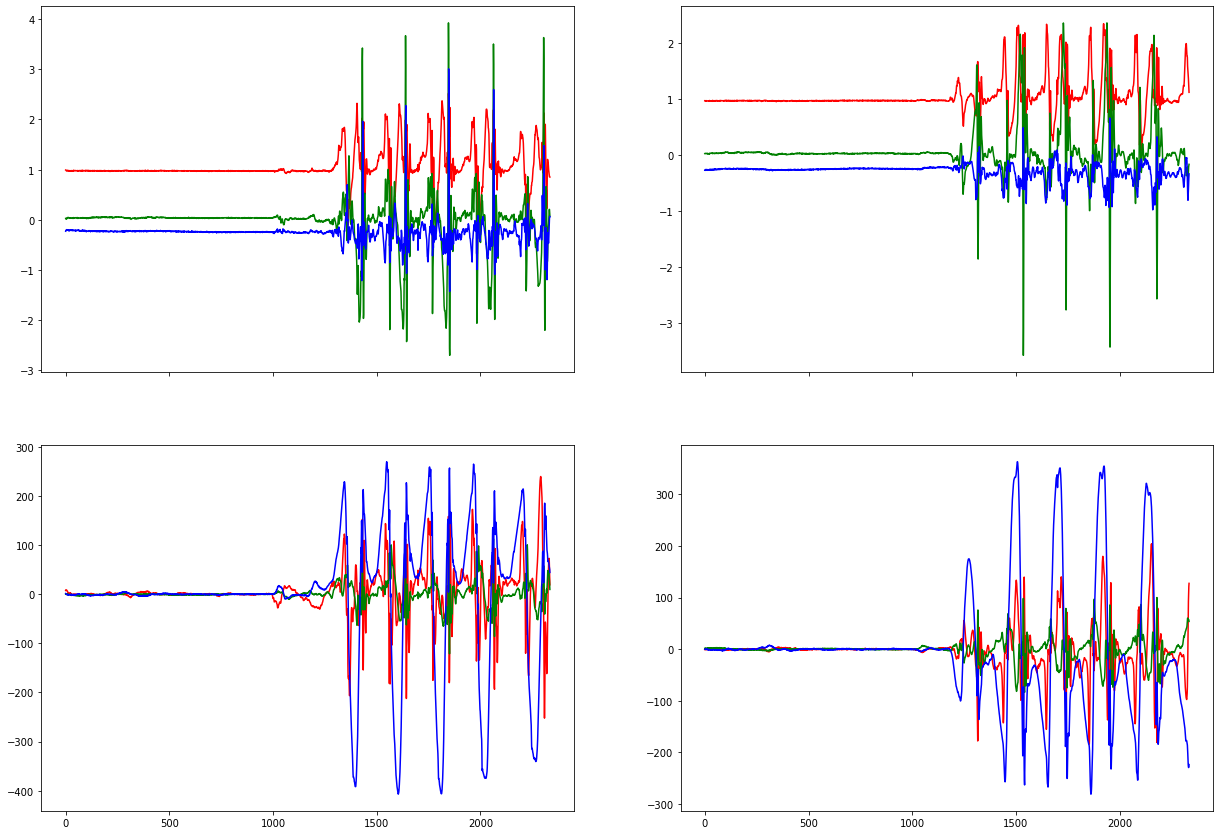

In [20]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(21.0, 14.8))
axs[0][0].plot(l_ank_acc[:,0], 'r')
axs[0][0].plot(l_ank_acc[:,1], 'g')
axs[0][0].plot(l_ank_acc[:,2], 'b')
axs[1][0].plot(l_ank_gyro[:,0], 'r')
axs[1][0].plot(l_ank_gyro[:,1], 'g')
axs[1][0].plot(l_ank_gyro[:,2], 'b')
axs[0][1].plot(r_ank_acc[:,0], 'r')
axs[0][1].plot(r_ank_acc[:,1], 'g')
axs[0][1].plot(r_ank_acc[:,2], 'b')
axs[1][1].plot(r_ank_gyro[:,0], 'r')
axs[1][1].plot(r_ank_gyro[:,1], 'g')
axs[1][1].plot(r_ank_gyro[:,2], 'b')
plt.show()

In [21]:
l_ank_acc, l_ank_gyro, l_ix_MS, l_ix_IC, l_ix_FC = _get_gait_events_from_IMU(imu_data, label="left_ankle")
r_ank_acc, r_ank_gyro, r_ix_MS, r_ix_IC, r_ix_FC = _get_gait_events_from_IMU(imu_data, label="right_ankle")

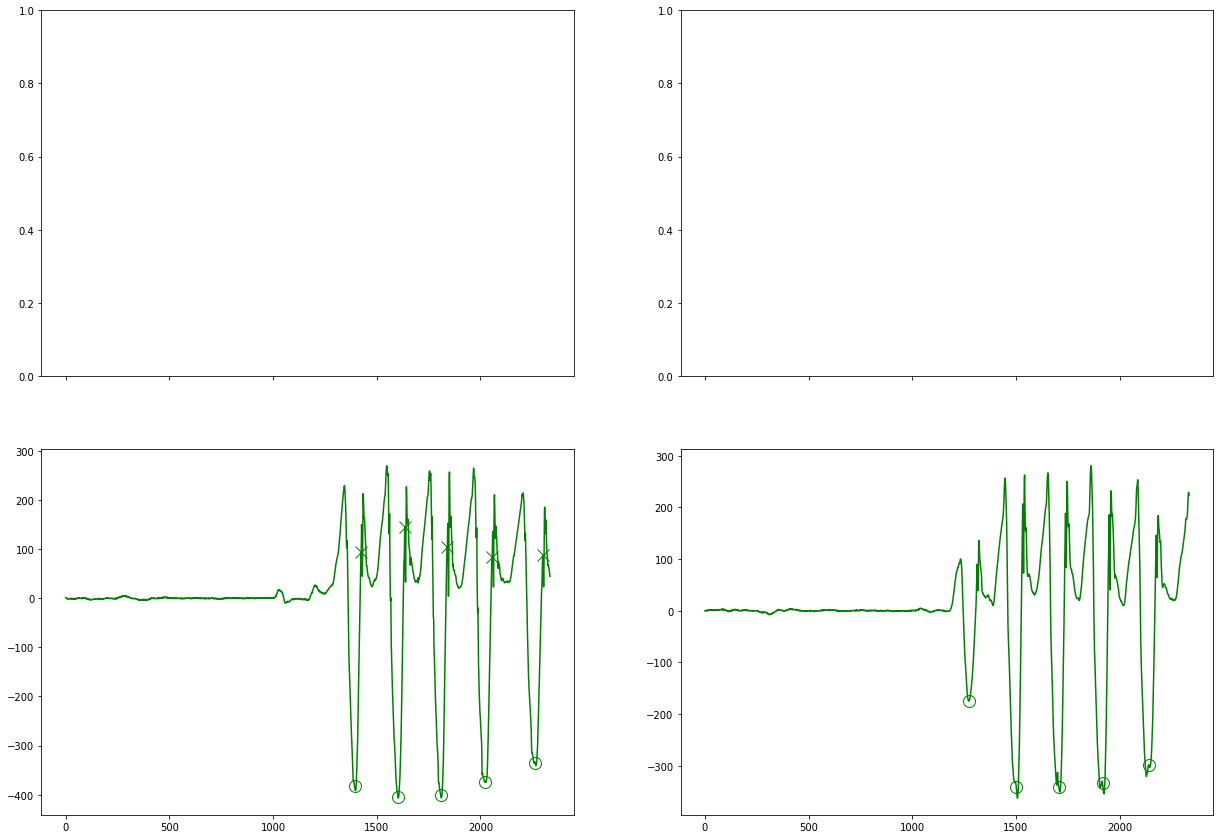

In [22]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(21.0, 14.8))
# axs[0][0].plot(l_ank_acc[:,0], 'r')
# axs[0][0].plot(l_ank_acc[:,1], 'g')
# axs[0][0].plot(l_ank_acc[:,2], 'b')
# axs[1][0].plot(l_ank_gyro[:,0], 'r')
axs[1][0].plot(l_ank_gyro[:,1], 'g')
axs[1][0].plot(l_ix_MS, l_ank_gyro[l_ix_MS,1], 'o', mfc='none', mec='g', ms=12)
axs[1][0].plot(l_ix_IC, l_ank_gyro[l_ix_IC,1], 'x', mfc='none', mec='g', ms=12)
# axs[1][0].plot(l_ank_gyro[:,2], 'b')
# axs[0][1].plot(r_ank_acc[:,0], 'r')
# axs[0][1].plot(r_ank_acc[:,1], 'g')
# axs[0][1].plot(r_ank_acc[:,2], 'b')
# axs[1][1].plot(r_ank_gyro[:,0], 'r')
axs[1][1].plot(r_ank_gyro[:,1], 'g')
axs[1][1].plot(r_ix_MS, r_ank_gyro[r_ix_MS,1], 'o', mfc='none', mec='g', ms=12)
# axs[1][1].plot(r_ank_gyro[:,2], 'b')
plt.show()

In [25]:
pks, pkprops = find_peaks(-r_ank_gyro[:,1], height=50.0, distance=fs_imu//2)

In [26]:
pks

array([ 366,  616,  836, 1049, 1274])

In [28]:
r_ix_MS

array([ 369,  616,  834, 1049, 1273, 1376])

In [29]:
participant_ids.index('pp069')

61